# Лабораторная работа 2

> =========================================
>
> Тема: Классификация, оченка точности классификации
>
> Набор данных: Настольные игры
>
> Студент: Цветков Иван ИУ7-22М
> 
>=========================================

## 0. Импорты

In [122]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import seaborn as sns
from kneed import KneeLocator
from collections import Counter
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import *
from sklearn.model_selection import *
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate

## 1. Данные

### 1.1. Чтение

In [123]:
pd.set_option('display.max_columns', None)

dfInit = pd.read_csv('./data/bgg_dataset.csv', delimiter=';', encoding='utf8')
del dfInit["ID"]


df = dfInit.copy(deep=True)

df

,Name,Year Published,Min Players,Max Players,Play Time,Min Age,Users Rated,Rating Average,BGG Rank,Complexity Average,Owned Users,Mechanics,Domains
0,Gloomhaven,2017.0,1,4,120,14,42055,"8,79",1,"3,86",68323.0,"Action Queue, Action Retrieval, Campaign / Bat...","Strategy Games, Thematic Games"
1,Pandemic Legacy: Season 1,2015.0,2,4,60,13,41643,"8,61",2,"2,84",65294.0,"Action Points, Cooperative Game, Hand Manageme...","Strategy Games, Thematic Games"
2,Brass: Birmingham,2018.0,2,4,120,14,19217,"8,66",3,"3,91",28785.0,"Hand Management, Income, Loans, Market, Networ...",Strategy Games
3,Terraforming Mars,2016.0,1,5,120,12,64864,"8,43",4,"3,24",87099.0,"Card Drafting, Drafting, End Game Bonuses, Han...",Strategy Games
4,Twilight Imperium: Fourth Edition,2017.0,3,6,480,14,13468,"8,70",5,"4,22",16831.0,"Action Drafting, Area Majority / Influence, Ar...","Strategy Games, Thematic Games"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
20338,War,0.0,2,2,30,4,1340,"2,28",20340,1,427.0,NaN,Children's Games
20339,Bingo,1530.0,2,99,60,5,2154,"2,85",20341,"1,05",1533.0,"Betting and Bluffing, Bingo, Pattern Recognition",Party Games
20340,Candy Land,1949.0,2,4,30,3,4006,"3,18",20342,"1,08",5788.0,Roll / Spin and Move,Children's Games
20341,Chutes and Ladders,-200.0,2,6,30,3,3783,"2,86",20343,"1,02",4400.0,"Dice Rolling, Grid Movement, Race, Roll / Spin...",Children's Games


### 1.2. Преобразование

In [124]:
df = df[df["Min Players"] != 9]
df = df[df["Min Players"] != 10]

del df["Name"]
del df["Mechanics"]
del df["Domains"]
# df.drop("Min Players", axis=1, inplace=True)
df.dropna(axis=0, inplace=True)

# Приведение данных к числу
df["Rating Average"] = df["Rating Average"].str.replace(",", ".")
df["Rating Average"] = df["Rating Average"].map(lambda elem: float(elem))

df["Complexity Average"] = df["Complexity Average"].str.replace(",", ".")
df["Complexity Average"] = df["Complexity Average"].map(lambda elem: float(elem))

df

,Year Published,Min Players,Max Players,Play Time,Min Age,Users Rated,Rating Average,BGG Rank,Complexity Average,Owned Users
0,2017.0,1,4,120,14,42055,8.79,1,3.86,68323.0
1,2015.0,2,4,60,13,41643,8.61,2,2.84,65294.0
2,2018.0,2,4,120,14,19217,8.66,3,3.91,28785.0
3,2016.0,1,5,120,12,64864,8.43,4,3.24,87099.0
4,2017.0,3,6,480,14,13468,8.70,5,4.22,16831.0
...,...,...,...,...,...,...,...,...,...,...
20338,0.0,2,2,30,4,1340,2.28,20340,1.00,427.0
20339,1530.0,2,99,60,5,2154,2.85,20341,1.05,1533.0
20340,1949.0,2,4,30,3,4006,3.18,20342,1.08,5788.0
20341,-200.0,2,6,30,3,3783,2.86,20343,1.02,4400.0


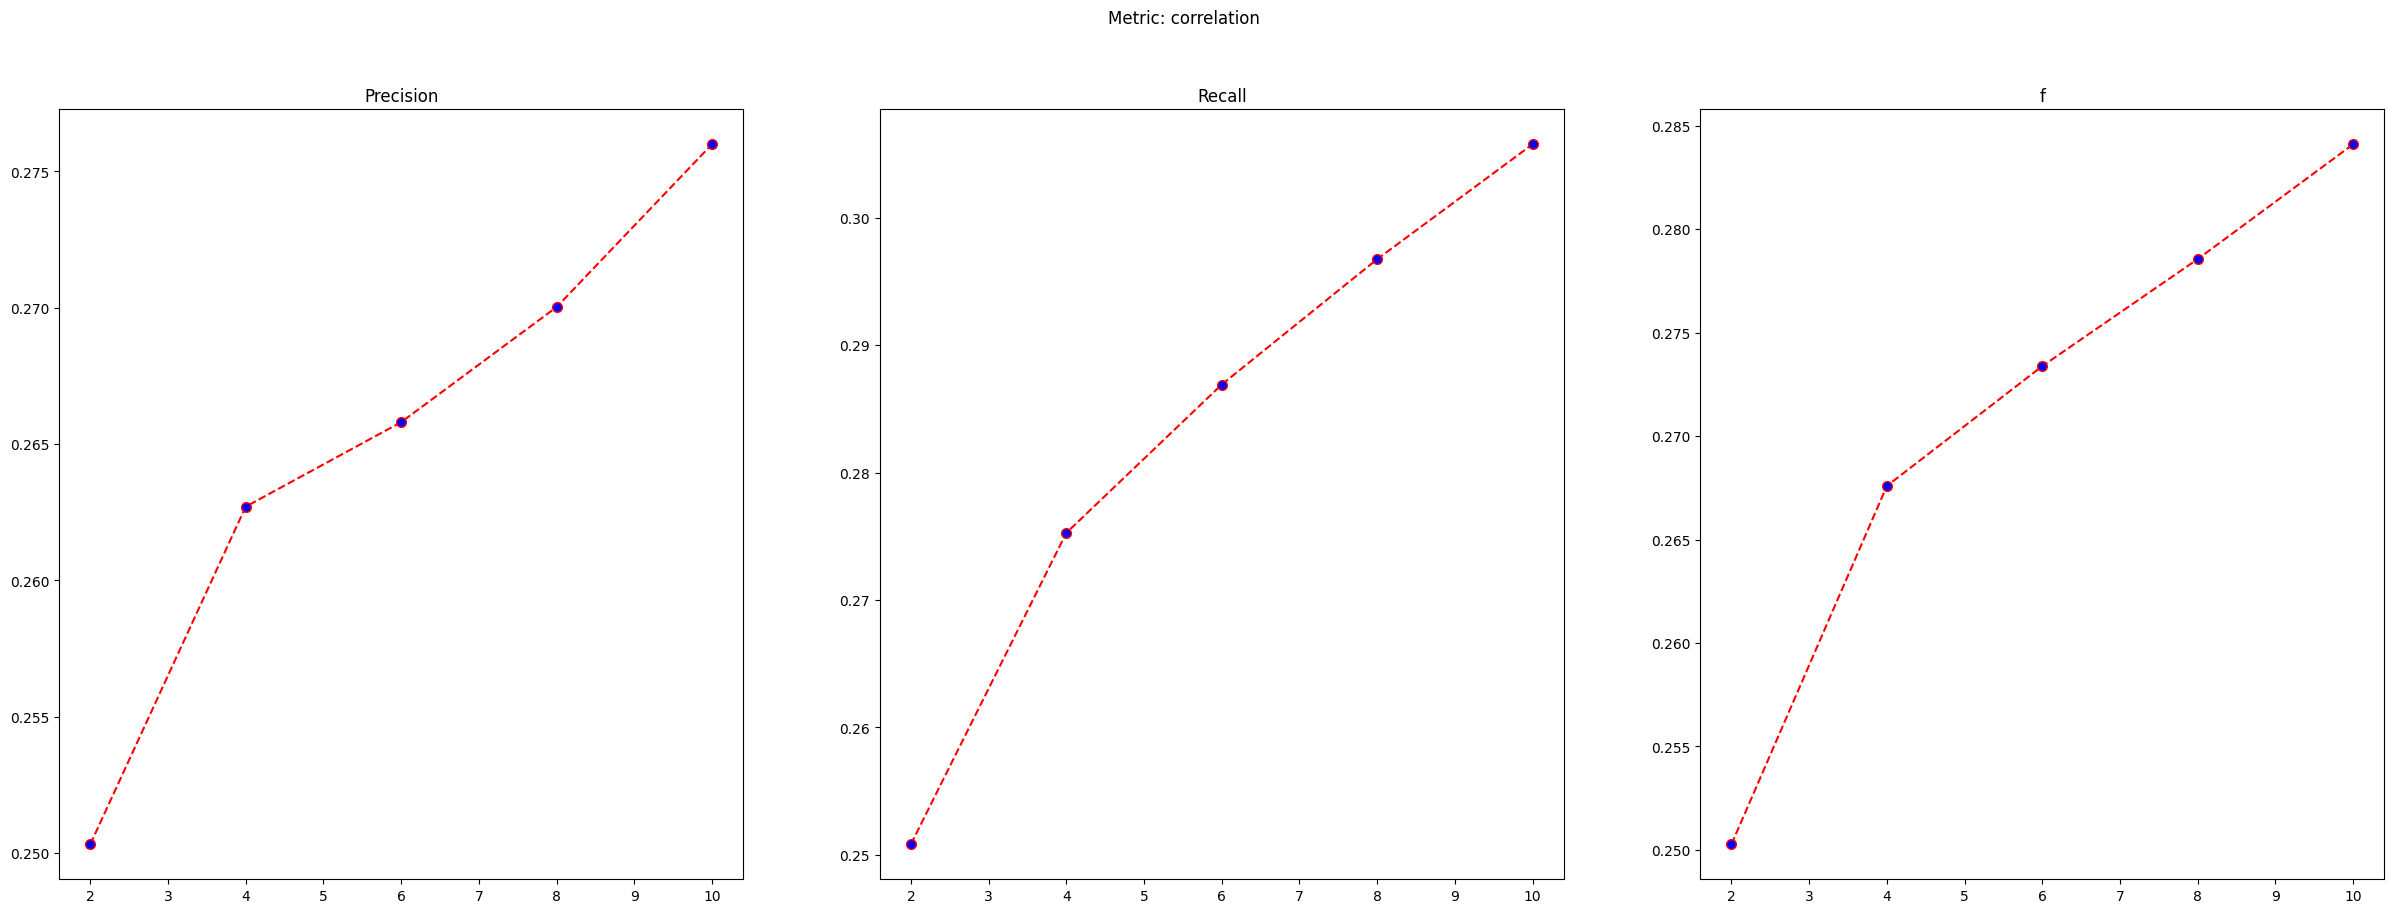

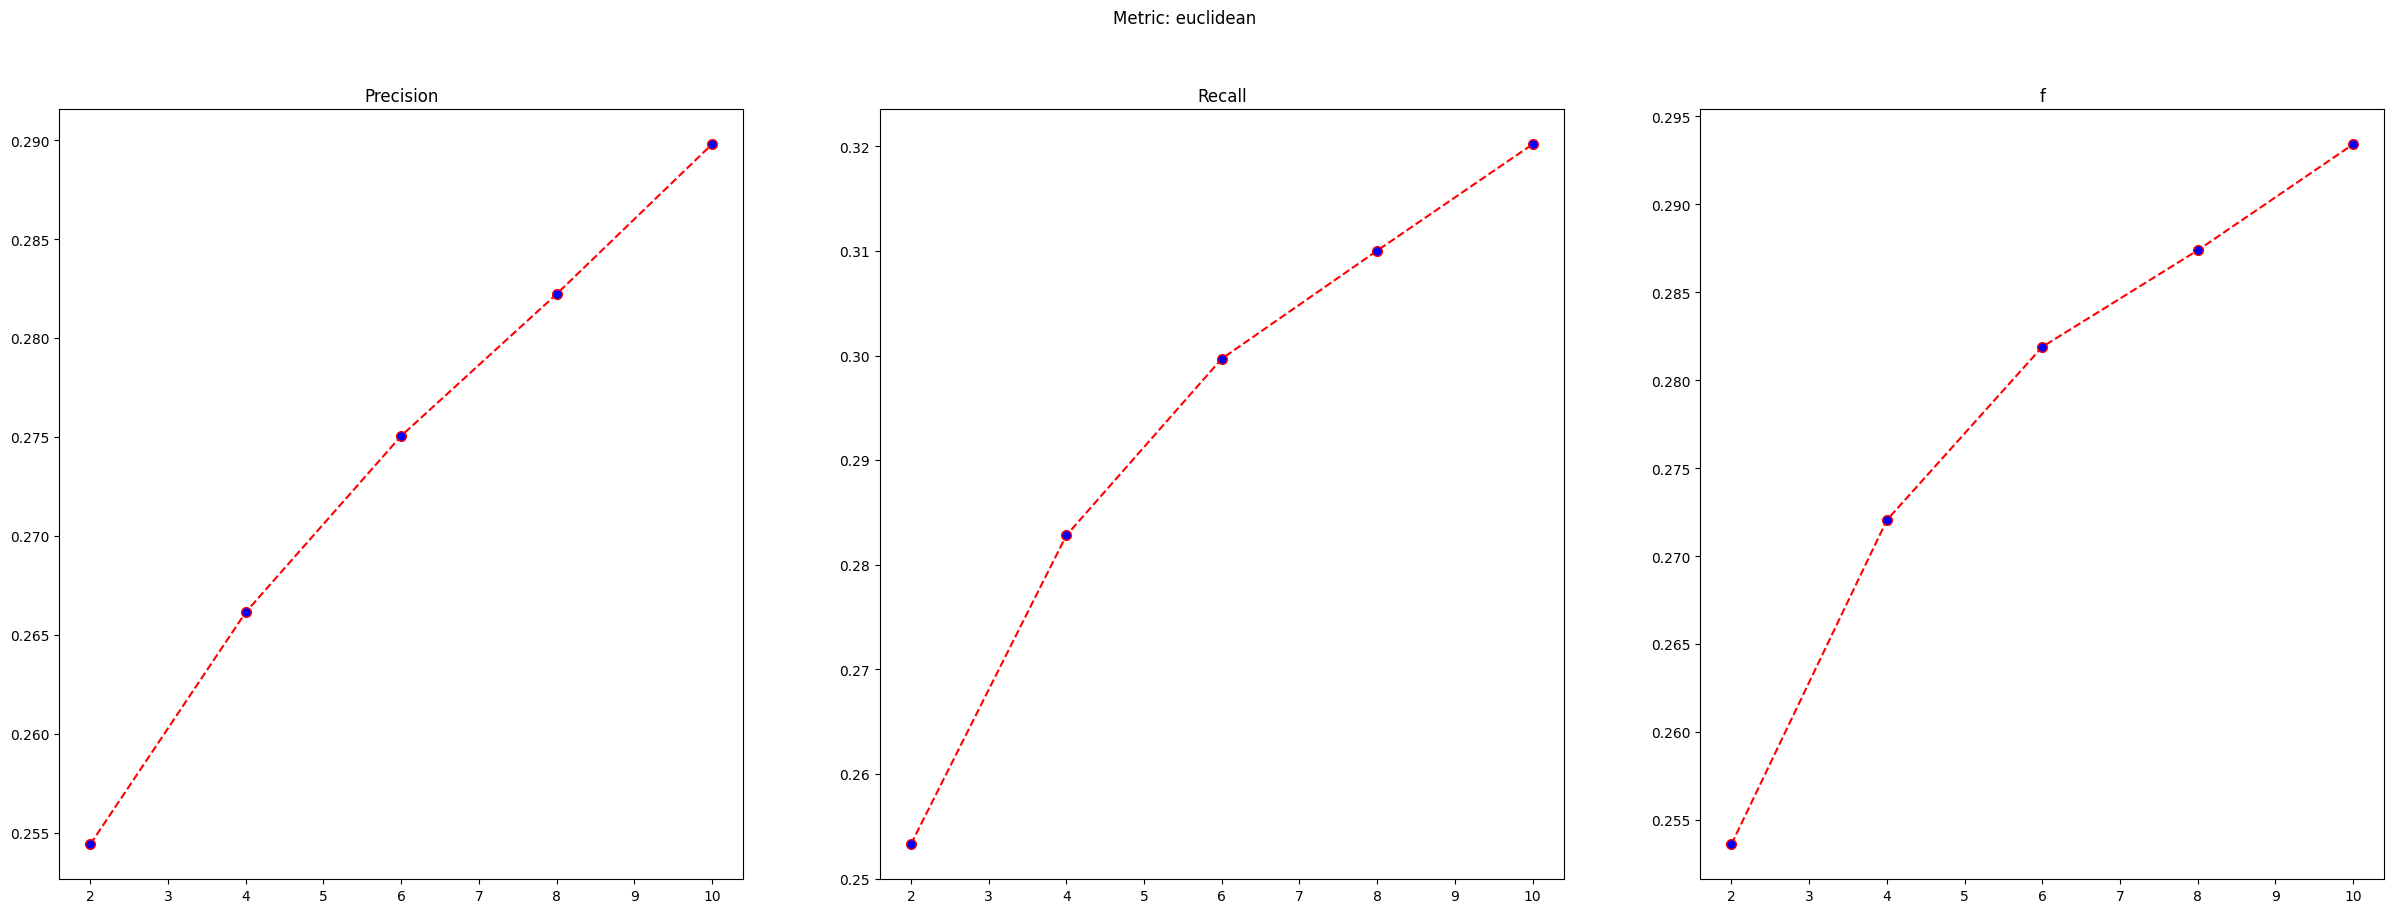

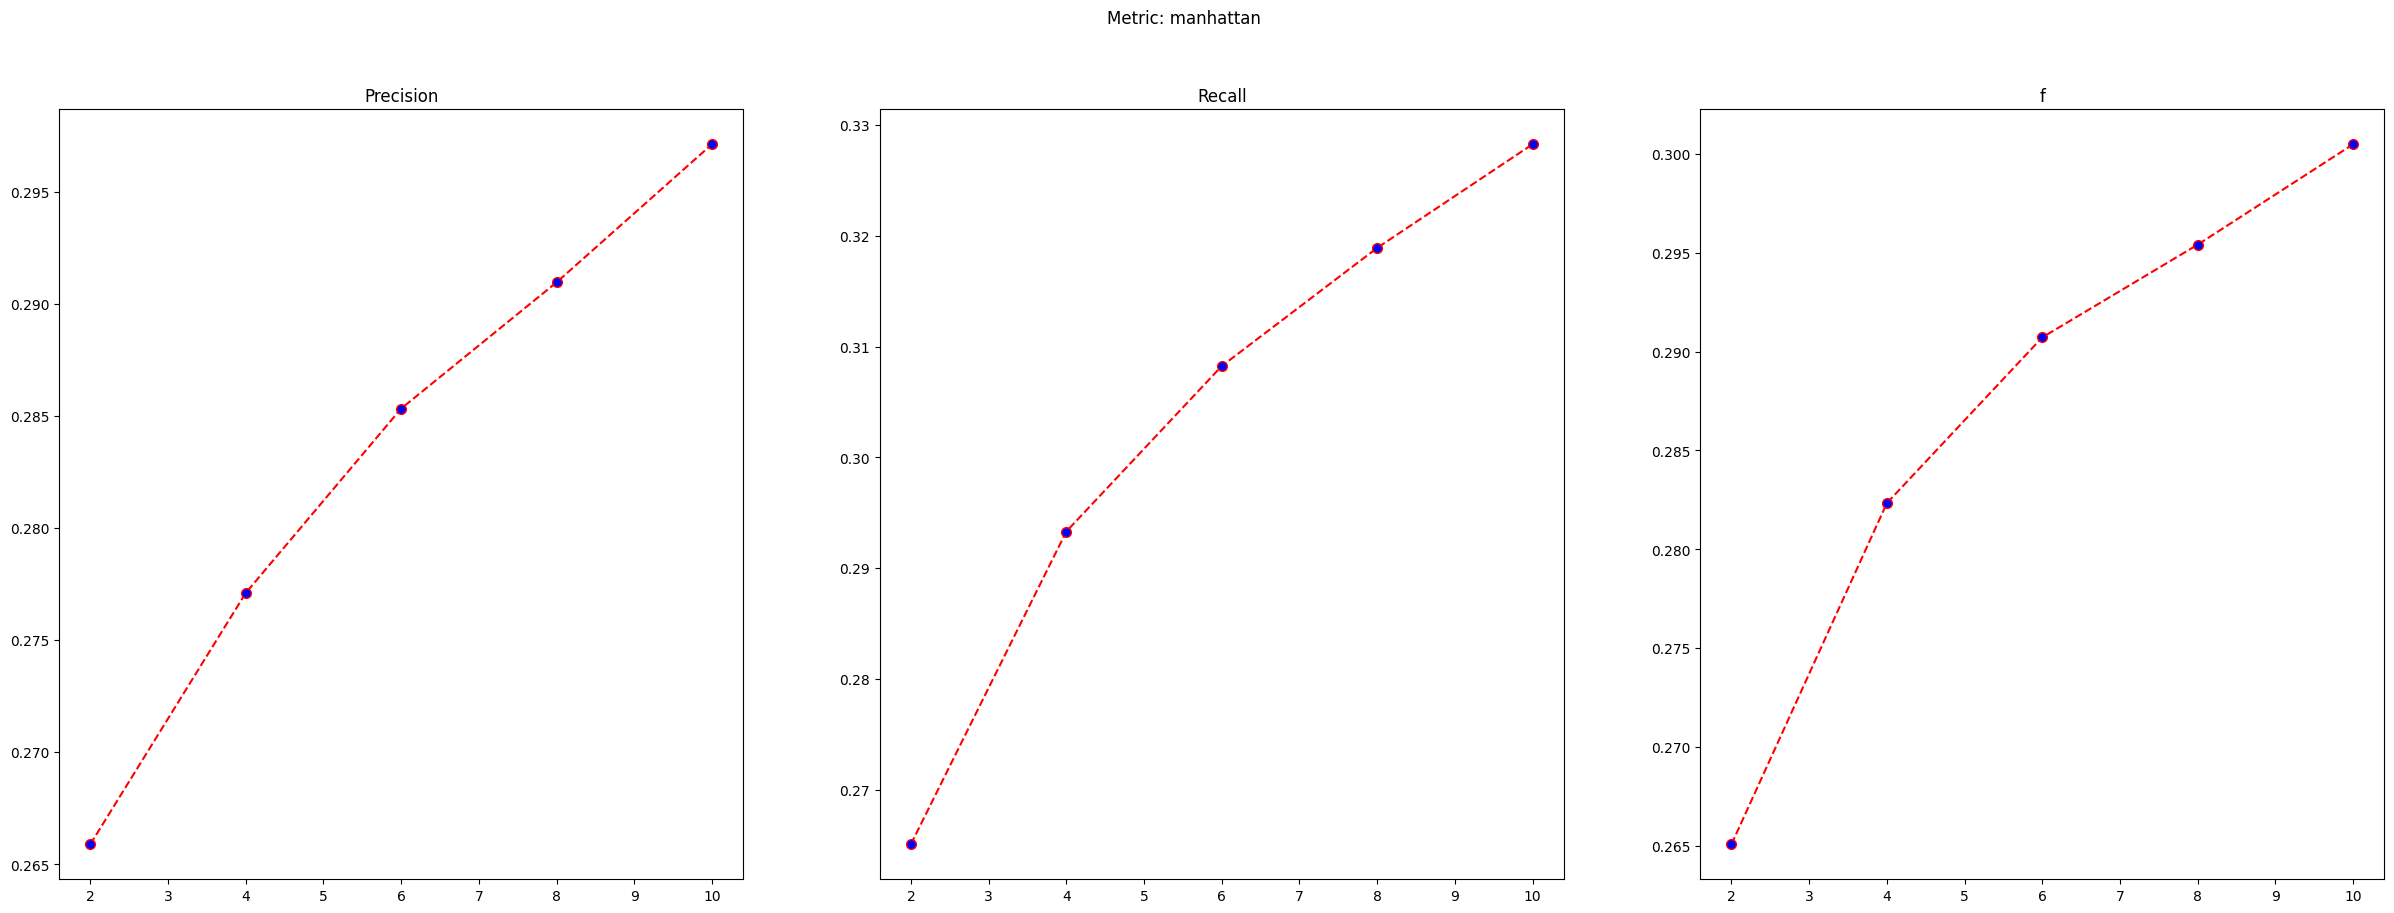

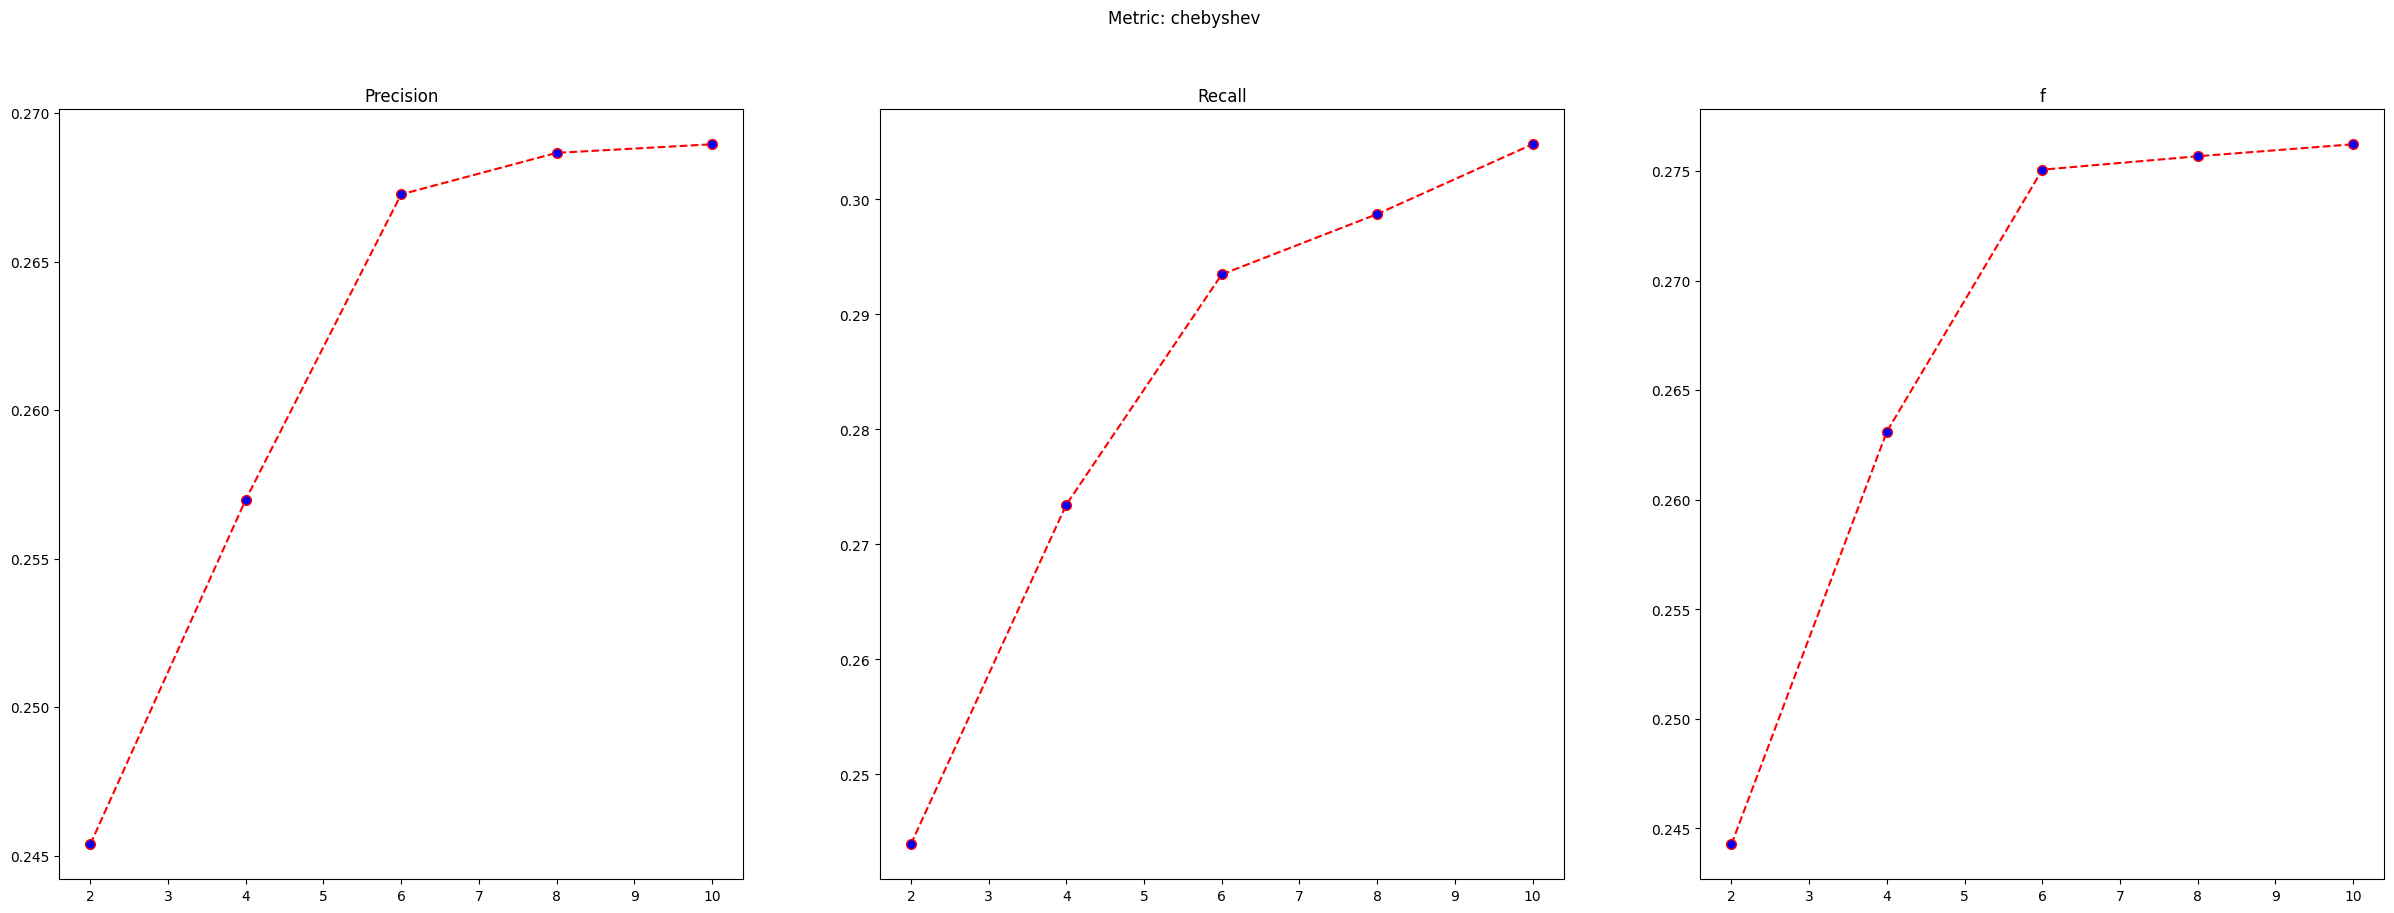

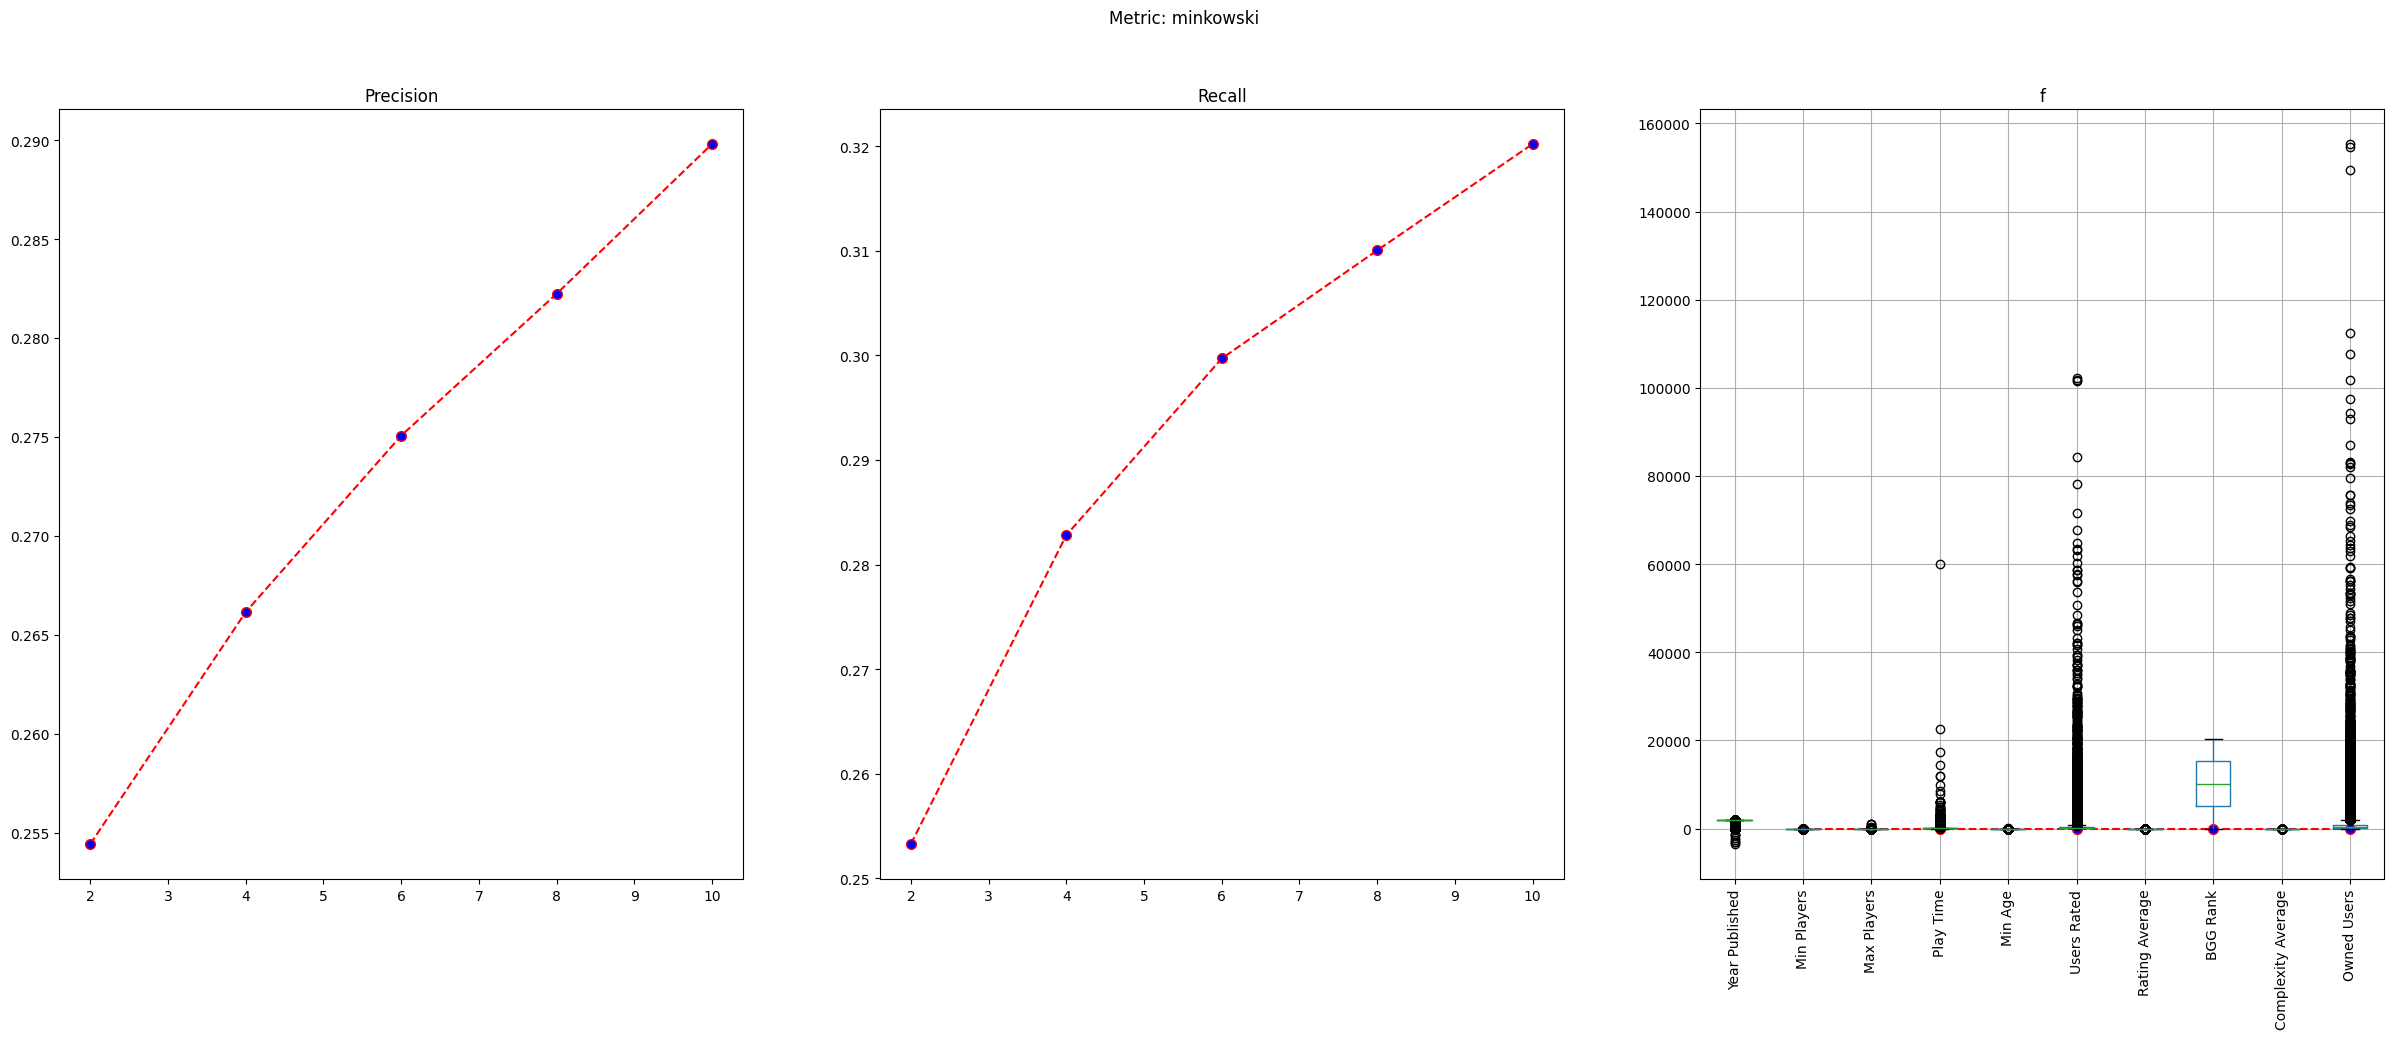

In [125]:
ax = df.boxplot(column=list(df.columns),figsize=(18,8))
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)

ax
plt.show()

## 2. Выполнение

### 2.1. Разделение на обучающие и тестовые данные

In [126]:
x = df.drop(["Min Players"], axis=1)
y = df["Min Players"]

In [127]:
xTraining, xTest, yTraining, yTest = train_test_split(x, y, test_size = 0.3, random_state=42)

In [128]:
scaler = StandardScaler()
scaler.fit(xTraining)
xTraining = scaler.transform(xTraining)
xTest = scaler.transform(xTest)

In [129]:
labelEncoder = preprocessing.LabelEncoder()
yTrainingEncoded = labelEncoder.fit_transform(yTraining)

### 2.2. k-ближайших соседей

In [130]:
import warnings
warnings.filterwarnings("ignore") # убрать FutureWarning (возникает в KMeans функции)

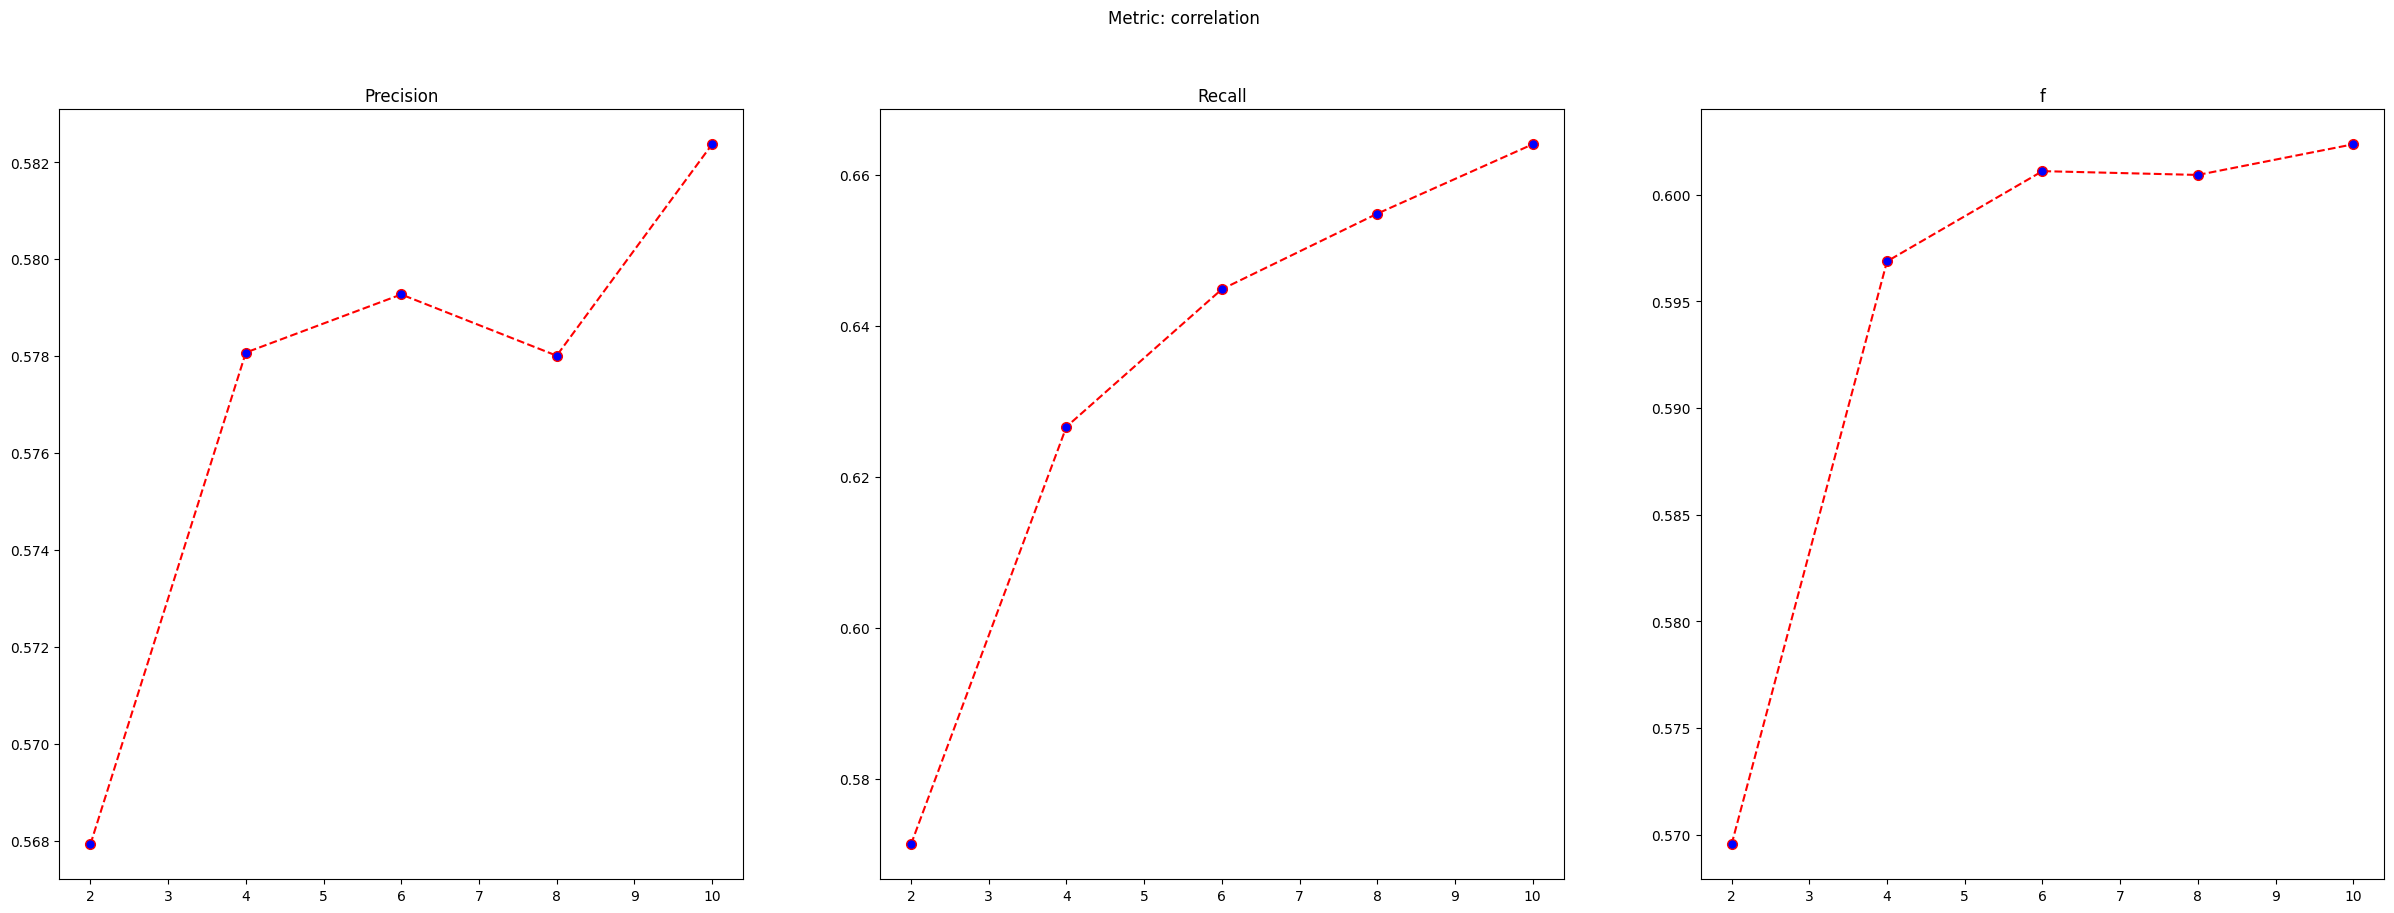

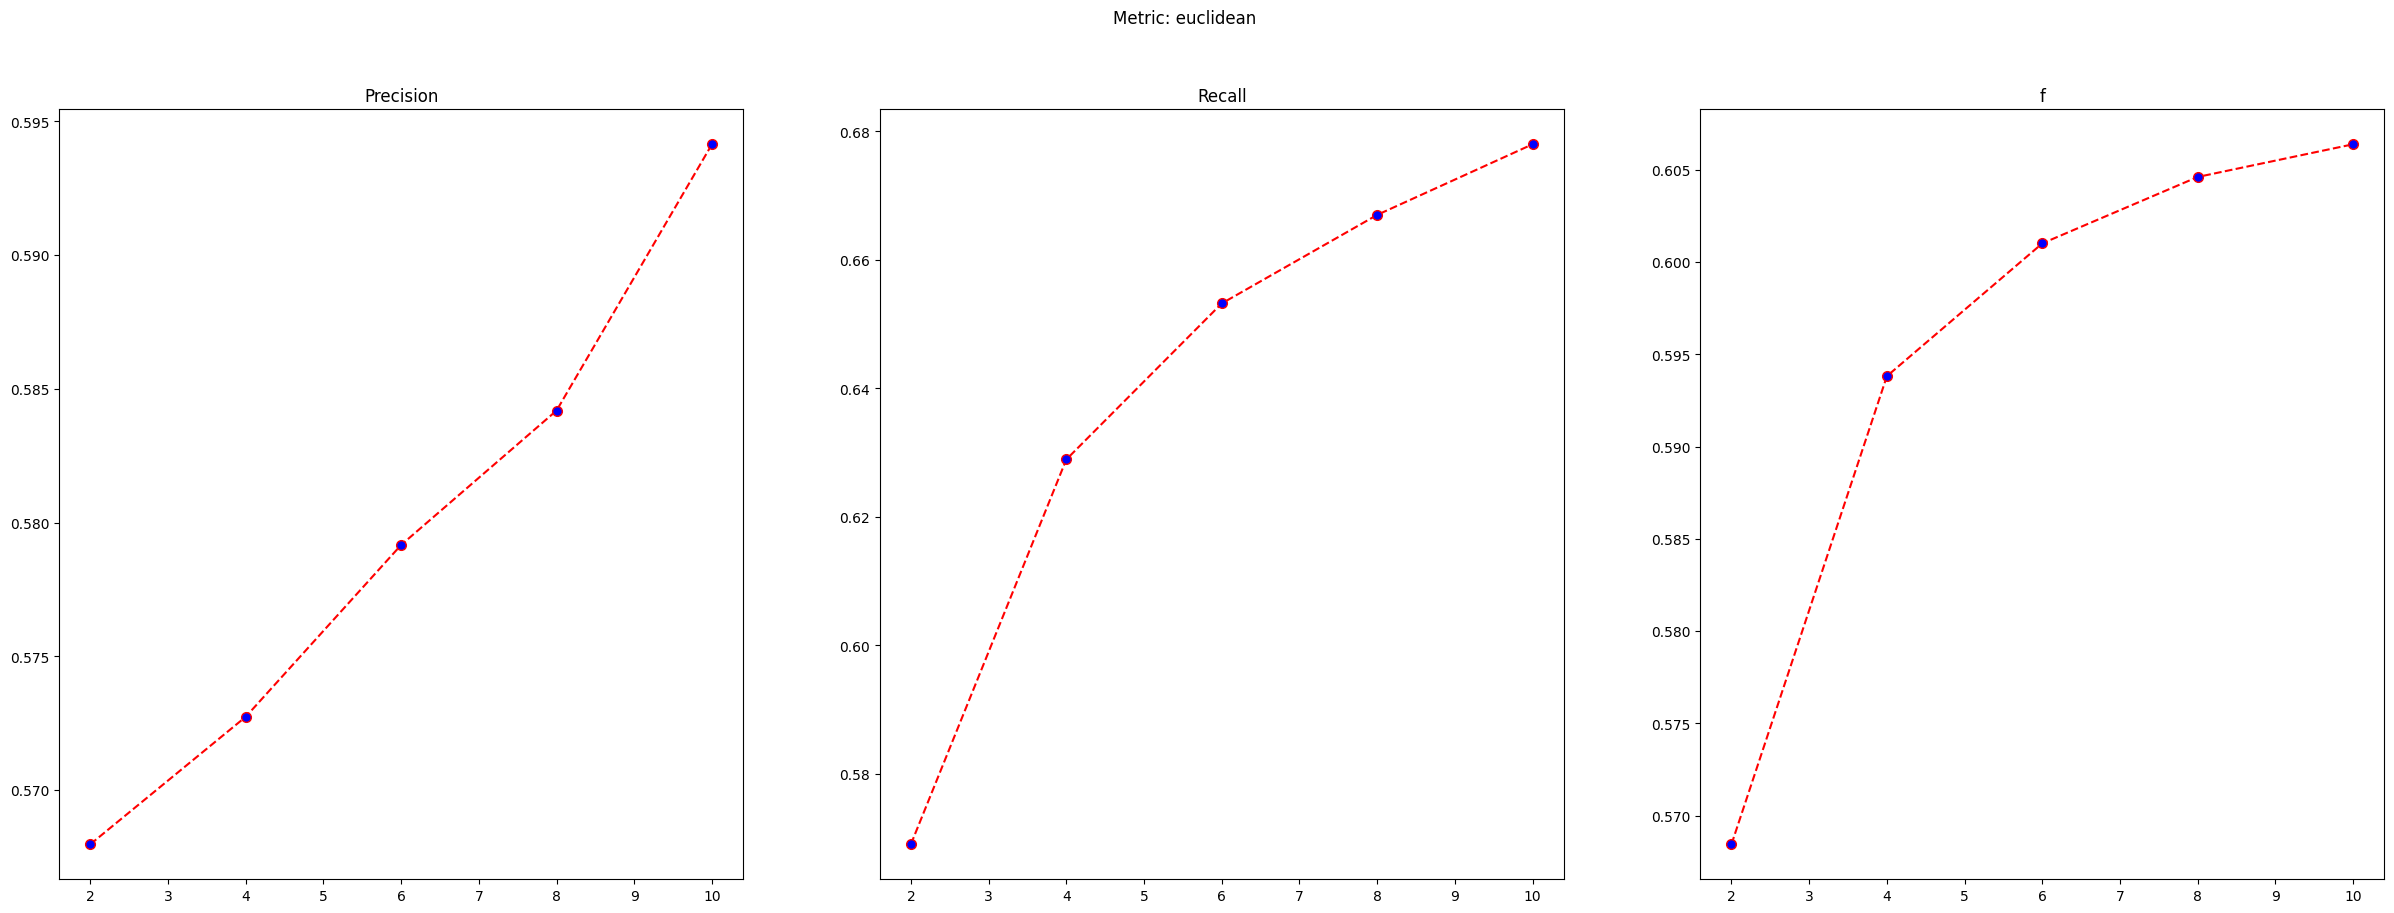

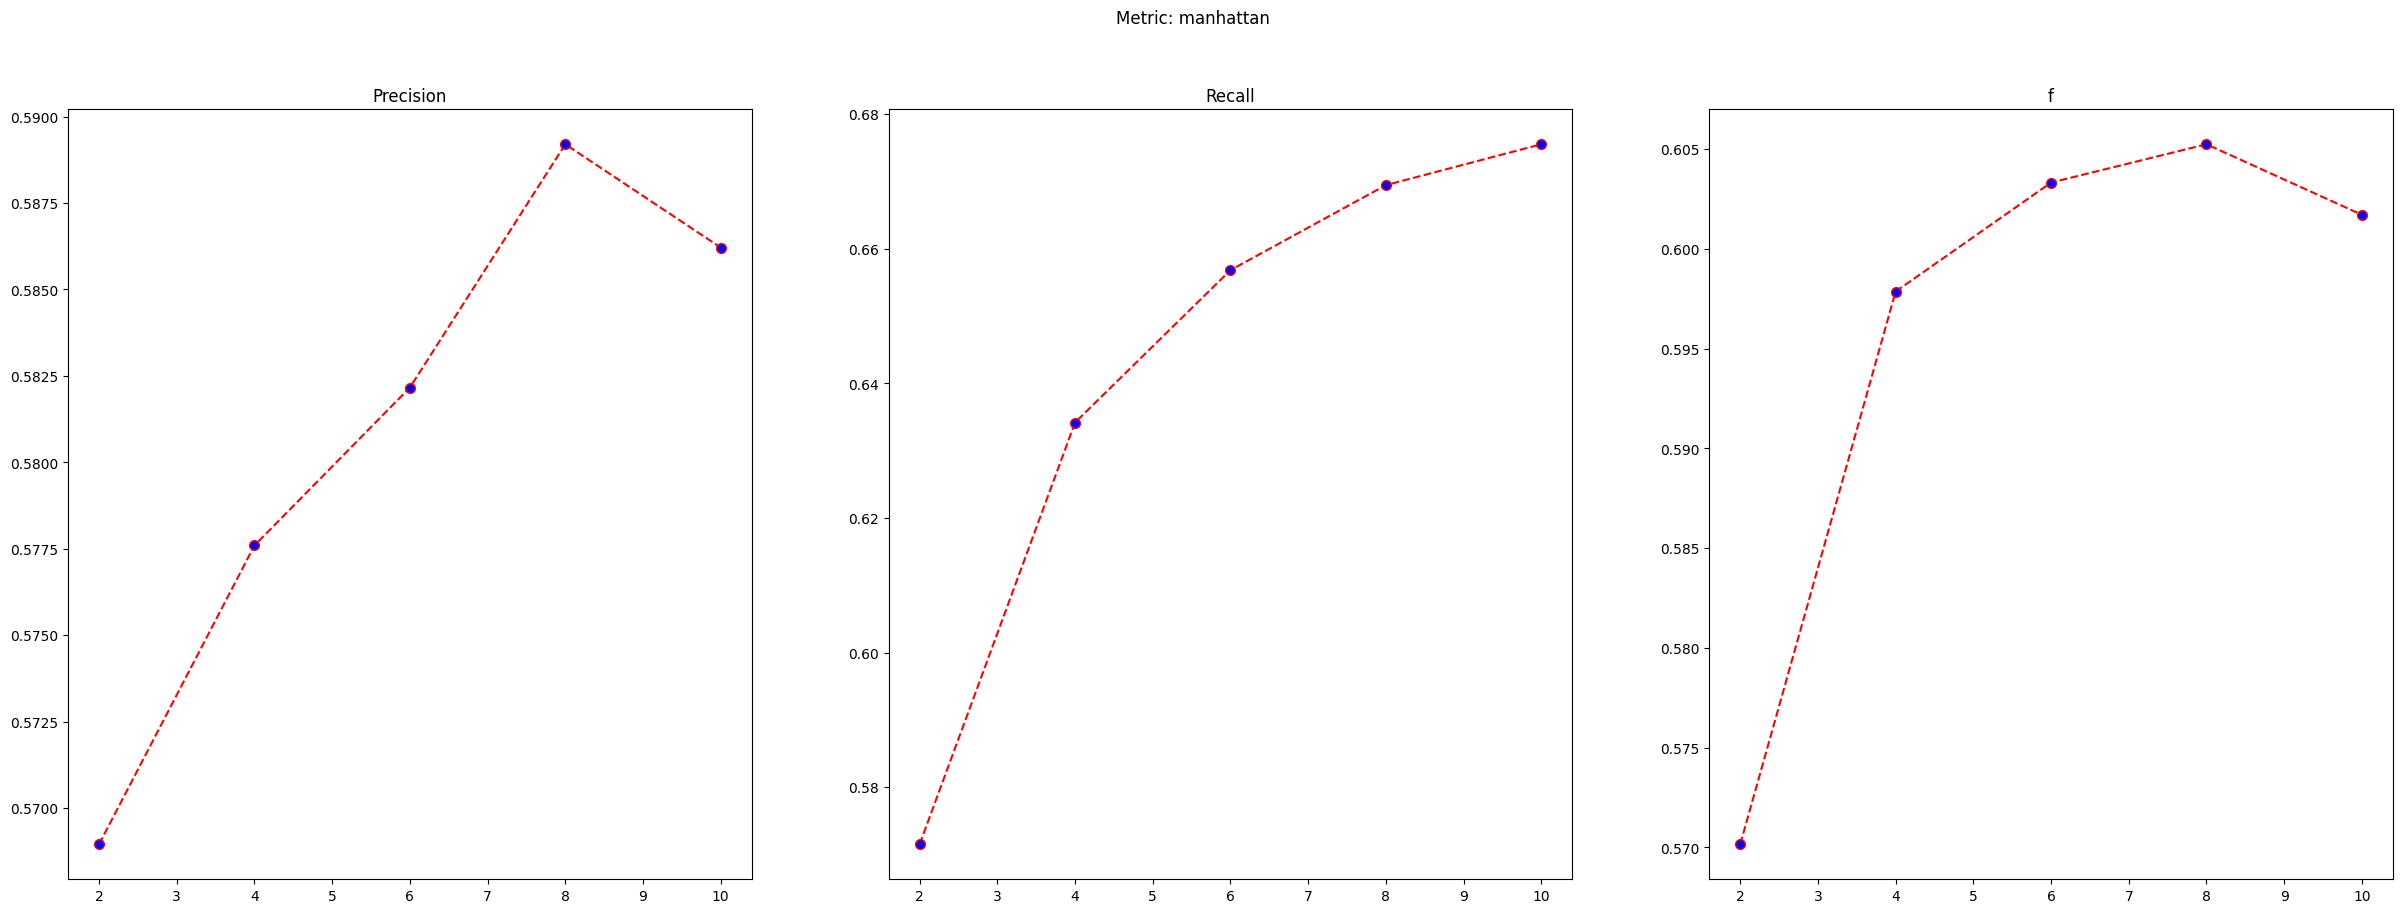

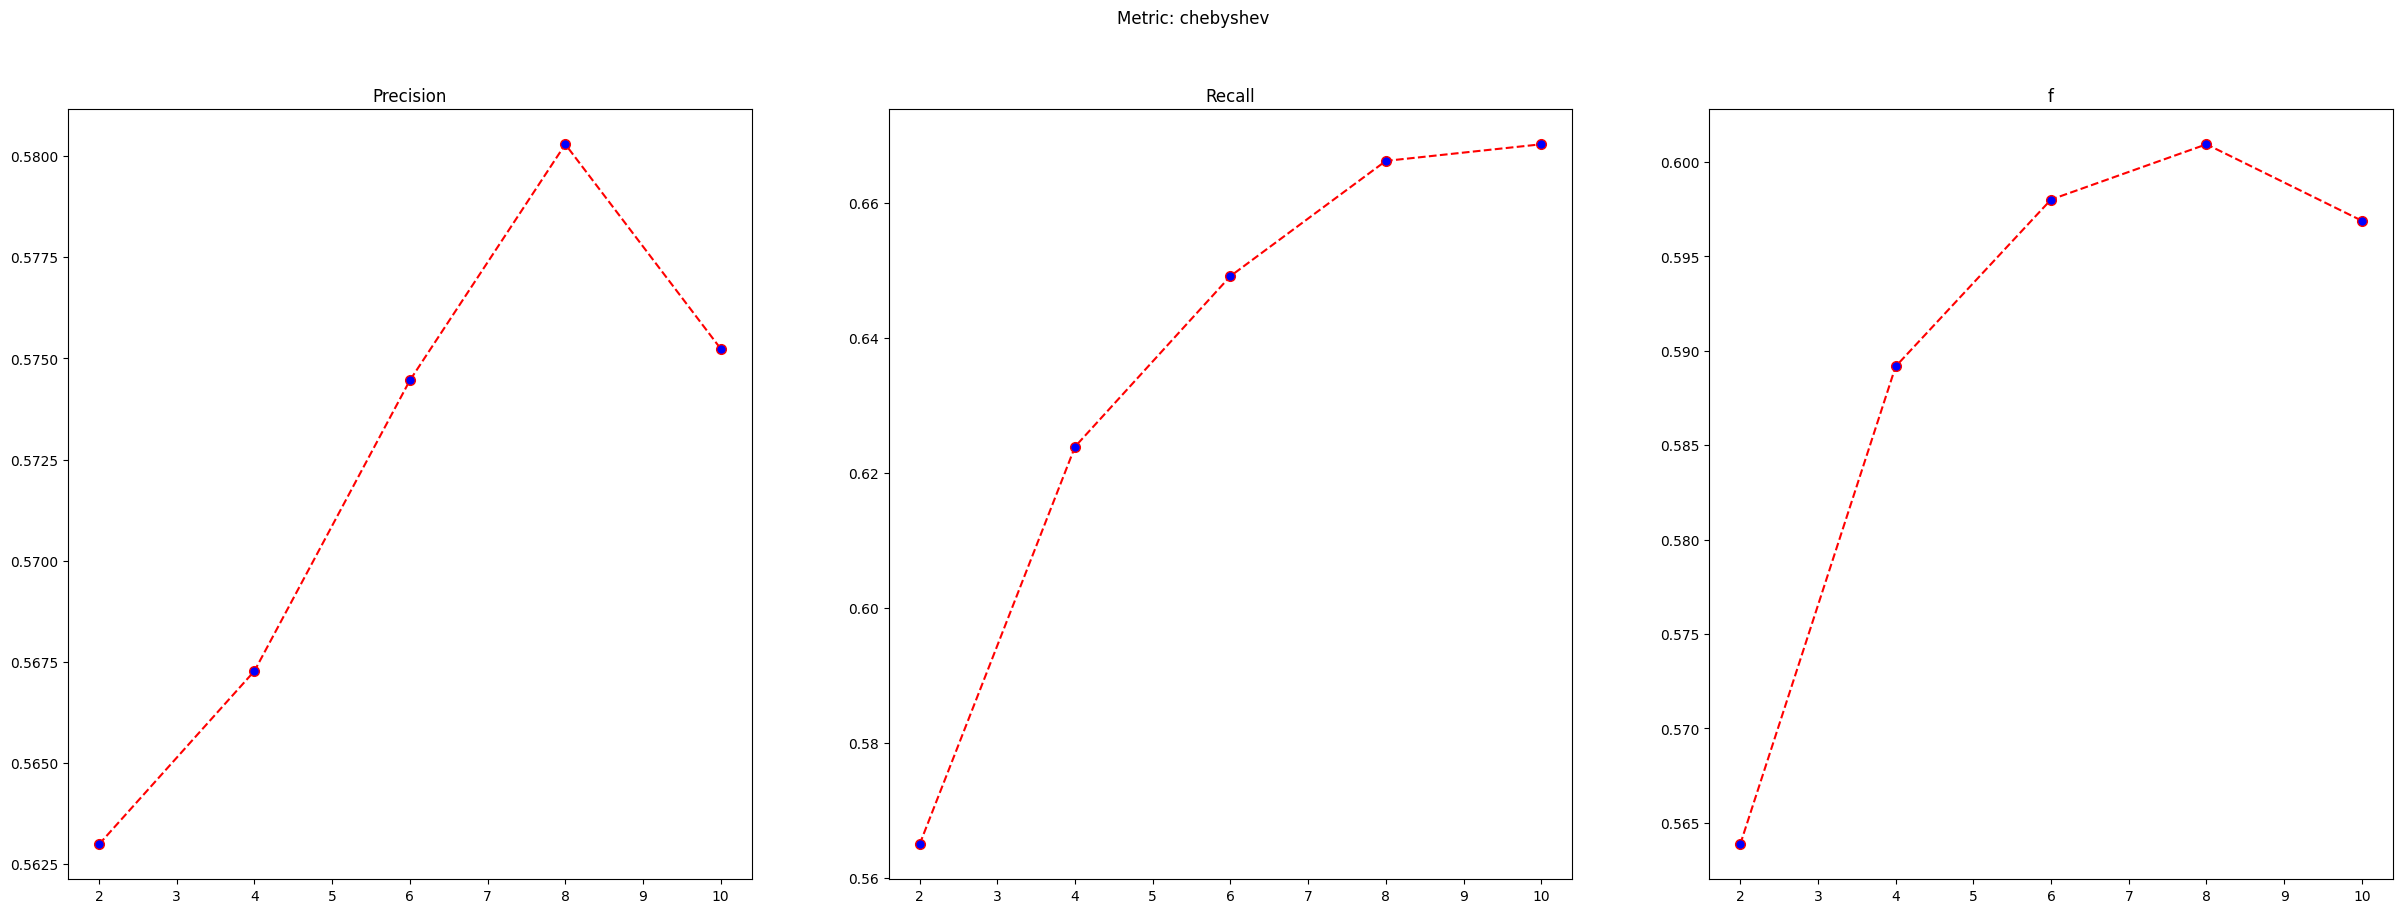

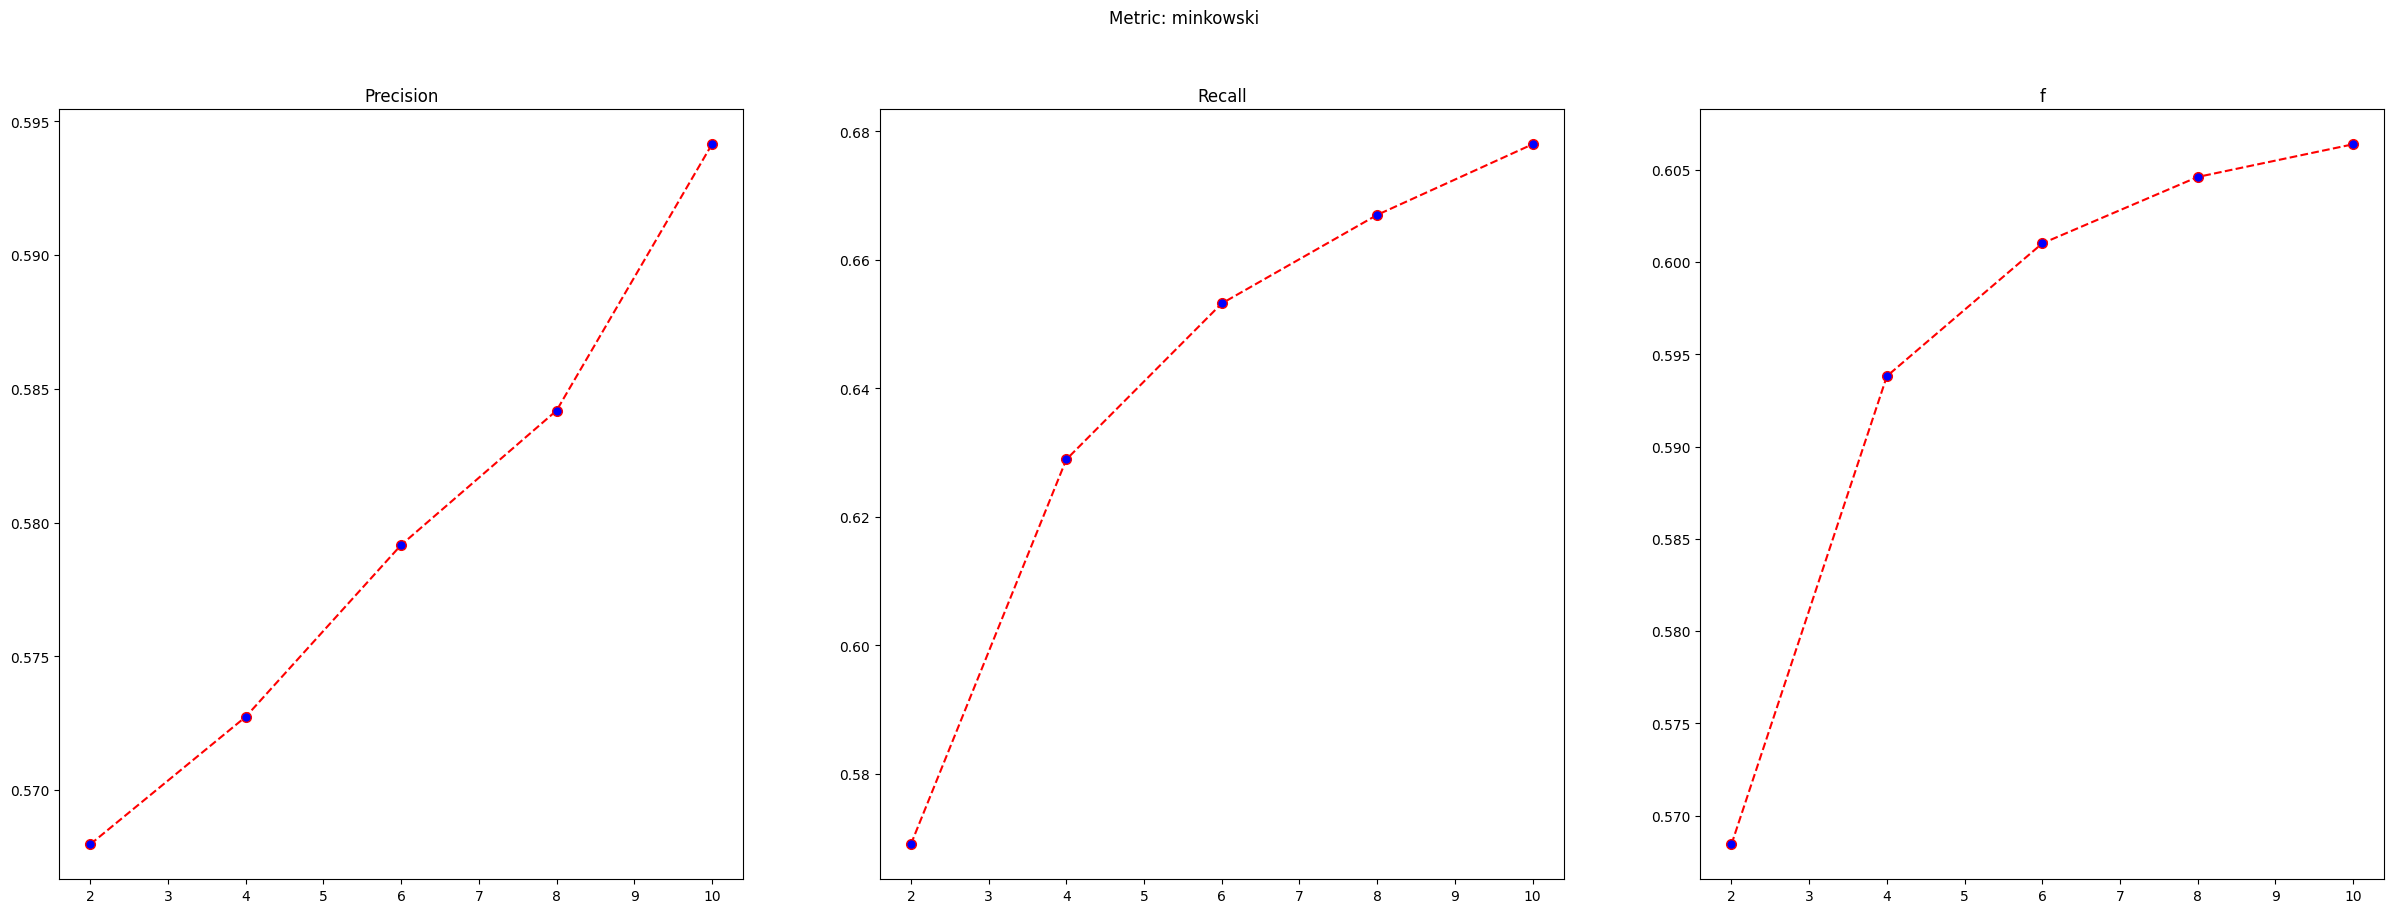

In [137]:
def doKNeightbors(m):
  precisionArr = []
  recallArr = []
  fArr = []

  neighborsRange = range(2, 12, 2)

  for i in neighborsRange:
    knn = KNeighborsClassifier(n_neighbors=i, weights='distance', metric=m)
    knn.fit(xTraining, yTraining)
    predict = knn.predict(xTest).tolist()

    metricsData = precision_recall_fscore_support(yTest, predict, average='weighted')

    precisionArr.append(np.average(metricsData[0]))
    recallArr.append(np.average(metricsData[1]))
    fArr.append(np.average(metricsData[2]))

  fig, ax = plt.subplots(1, 3, figsize=(30, 10))
  ax[0].plot(neighborsRange, precisionArr, color='red', linestyle='dashed', marker='o', markerfacecolor='blue', markersize=7)
  ax[1].plot(neighborsRange, recallArr, color='red', linestyle='dashed', marker='o', markerfacecolor='blue', markersize=7)
  ax[2].plot(neighborsRange, fArr, color='red', linestyle='dashed', marker='o', markerfacecolor='blue', markersize=7)

  ax[0].set_title("Precision")
  ax[1].set_title("Recall")
  ax[2].set_title("f")

  fig.suptitle("Metric: " + m)

for m in ["correlation", "euclidean", "manhattan", "chebyshev", "minkowski"]:
  doKNeightbors(m)

plt.show()

### 2.3. Confusion Matrix

In [138]:
minAgeNames = df["Min Players"].unique()
minAgeNames.sort()
print(minAgeNames)

[0 1 2 3 4 5 6 7 8]


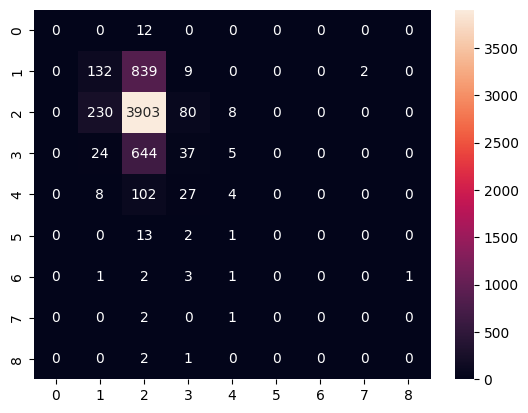

In [139]:
knn = KNeighborsClassifier(n_neighbors=10, weights='distance', metric='chebyshev')
knn.fit(xTraining, yTraining)
predictions = knn.predict(xTest).tolist()

confusionMatrix = confusion_matrix(yTest, predictions)
cm = pd.DataFrame(confusionMatrix, columns=minAgeNames, index = minAgeNames)
                  
sns.heatmap(cm, annot=True, fmt='d')
plt.show()

### 2.4. Метрики

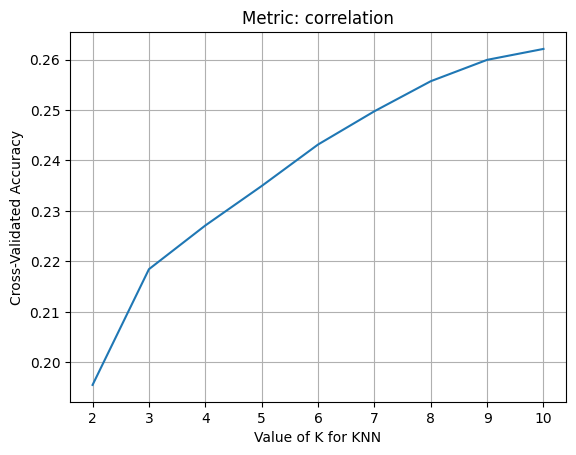

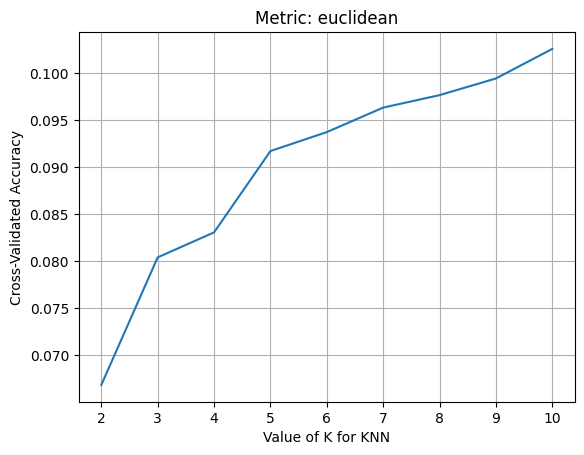

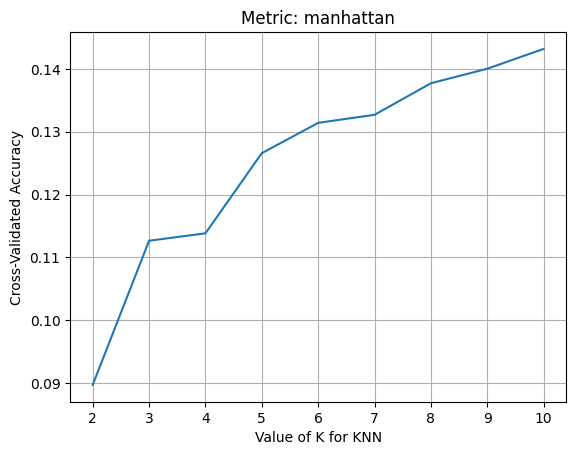

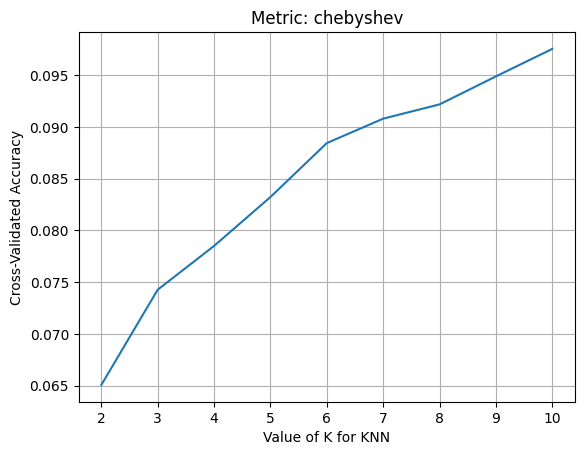

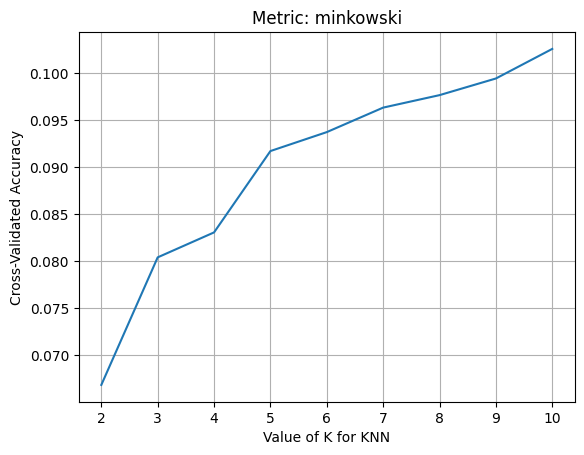

In [140]:
def doKNeightbors(m):
  kScores = []

  neighborsRange = range(2, 11)

  for i in neighborsRange:
    knn = KNeighborsClassifier(n_neighbors=i, weights='distance', metric=m)
    kScores.append(cross_val_score(knn, df, y, cv=5, scoring='accuracy').mean())

  plt.plot(neighborsRange, kScores)
  plt.title("Metric: " + m)
  plt.xlabel('Value of K for KNN')
  plt.ylabel('Cross-Validated Accuracy')
  plt.grid()
  plt.show()

for m in ["correlation", "euclidean", "manhattan", "chebyshev", "minkowski"]:
  doKNeightbors(m)

### 2.5. Деревья принятия решений

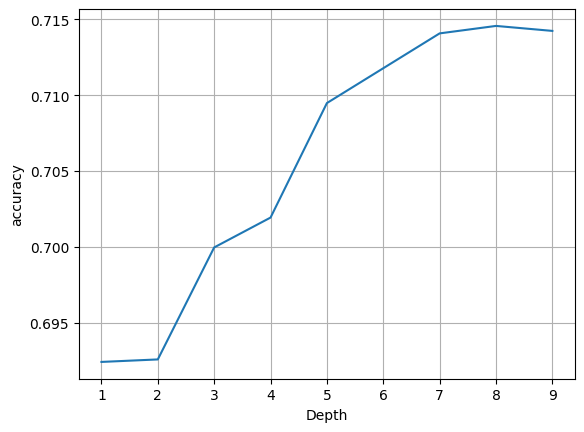

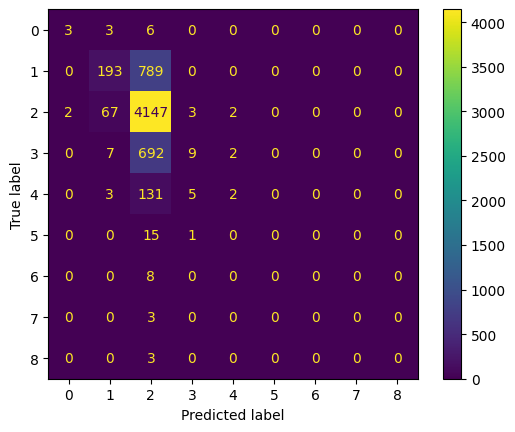

Max deep:  8
f1:  0.6271841140294038
Recall:  0.714238845144357
Precision:  0.6766034694560912


In [147]:
pltx = []
plty = []

for depth in range(1, 10):
    model = RandomForestClassifier(max_depth = depth).fit(xTraining, yTraining)
    predictions = model.predict(xTest)
    plty.append(accuracy_score(yTest, predictions))
    pltx.append(depth)

plt.plot(pltx, plty)
plt.xlabel('Depth')
plt.ylabel('accuracy')
plt.grid()
plt.show()

maxDepth = pltx[plty.index(max(plty))]
# pl = plot_confusion_matrix(model, xTest, yTest)
ConfusionMatrixDisplay.from_estimator(estimator=model, X=xTest, y=yTest)
plt.show()

print("Max deep: ", maxDepth)
print("f1: ", f1_score(yTest, predictions, average='weighted'))
print("Recall: ", recall_score(yTest, predictions, average='weighted'))
print("Precision: ", precision_score(yTest, predictions, average='weighted'))

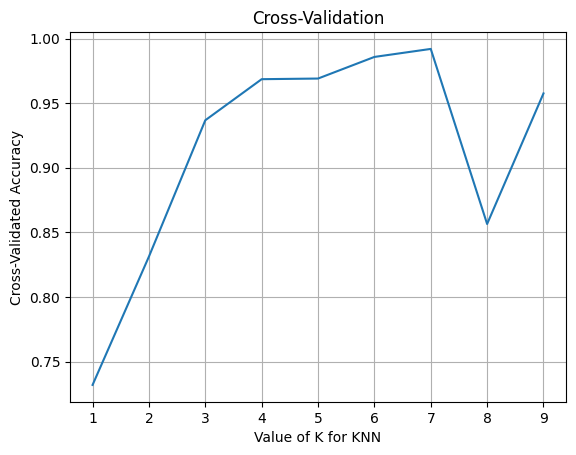

In [148]:
kScores = []
depthRange = range(1, 10)
for depth in depthRange:
  model = RandomForestClassifier(max_depth = depth).fit(xTraining, yTraining)
  kScores.append(cross_val_score(model, df, y, cv=5, scoring='accuracy').mean())

plt.plot(depthRange, kScores)
plt.title("Cross-Validation")
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated Accuracy')
plt.grid()
plt.show()